<h1 align="center">Bayesian Statistics, Demo 6</h1>

<br>

In [1]:
import pymc as pm
import bambi as bmb
import arviz as az
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

<h3 align="left">Task 2</h3>

Suppose $\, y_i|\theta \sim Bernoulli(\theta) \quad i=1,..,n, \,$ and the prior is $\, \theta \sim Uniform(0, 1). \,$ If the observations are exchangeable (independent given $\, \theta$), then the posterior is

$$ p(\theta|y) \propto \theta^s (1 - \theta)^{n-s}, \quad \, where \, \, s = \sum\limits_{i=1}^{n} y_i. $$

In the given context, let's assume that a dataset y (n=20) has been observed:

$$y <- c(1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0).$$

When examining the data, there is a suspicion that the observations are autocorrelated (long sequences of consecutive ones/zeros). Let's test this hypothesis in a Bayesian framework. We choose the test statistic T(y) to be the count of the consecutive 0-1 and 1-0 pairs (in the case of positive autocorrelation, T(y) will be small; in the case of negative autocorrelation, it will be large).

Determine the Bayes p-value for the independence hypothesis by calculating the proportion of posterior predictive samples that yield a test statistic greater than the original data's T(y) = 3. Utilize the information that under the assumption of exchangeability, the posterior distribution of $\, \theta \,$ follows a Beta distribution.

In [169]:
# Given data
y = np.array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
# The sum of observed successes
s = sum(y)
print(f"The sum of observed successes is {s}.")

The sum of observed successes is 7.


Note that beta distribution (without the gamma constant) has the following form:

$$ \theta^{\alpha - 1} (1 - \theta)^{\beta -1}. $$

Therefore our posterior distribution parameters should be s+1 and n-s+1, since

\begin{align*}
    p(\theta|y) &\propto \theta^{s} (1 - \theta)^{n-s} \\
    &= \theta^{(s+1)-1} (1 - \theta)^{(n-s+1)-1}.
\end{align*}

**Construct the Bayesian model**

In [170]:
with pm.Model() as model:
    
    # Prior
    theta = pm.Uniform('theta', lower=0, upper=1)
    
    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=y)
    
    trace = pm.sample(draws=2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


<br>

**Generate posterior predictive samples from a model given a trace.**

In [172]:
with model:
    pp = pm.sample_posterior_predictive(trace)

Sampling: [y_obs]


In [183]:
theta_posterior = pp['posterior_predictive']['y_obs'].values.flatten()
theta_posterior

array([1, 1, 1, ..., 1, 0, 0])

In [193]:
# Number of ones in the posterior predictive distribution
np.count_nonzero(theta_posterior == 1)

57921

In [194]:
# Number of zeros in the posterior predictive distribution
len(theta_posterior) - np.count_nonzero(theta_posterior == 1)

102079

In [184]:
def calculate_pairs(y):
    """
    Calculate the number of 0-1 and 1-0 pairs in the input sequence.

    Parameters:
        y (list): A list representing a sequence of binary values (0 or 1).

    Returns:
        int: The number of pairs where the current element is different from the previous one.
    """
    num_pairs = 0
    for i in range(len(y)-1):
        if (y[i+1] == 1 and y[i] == 0) or (y[i+1] == 0 and y[i] == 1):
            num_pairs += 1
    return num_pairs

In [185]:
calculate_pairs(theta_posterior)

70729

- Note that the same functionality of calculating the 0-1 and 1-0 pairs can be achieved by using the **diff()** function (together with the built-in sum and abs functions) provided by the NumPy library, as illustrated below.

In [186]:
sum(abs(np.diff(theta_posterior)))

70729

Now one needs to sample (n=20) from the posterior distribution in order to calculate the Bayesian p-value.

In [188]:
# Draw 10000 samples (n=20) from the posterior distribution

n_samples = 10000    # number of samples
samples = []         # a list used to store the samples

# Generate samples
for _ in range(n_samples):
    
    # Randomly select a sample of size=20 from the posterior distribution
    sample = np.random.choice(theta_posterior, size=20, replace=False)
    
    # Add the random sample to the samples list
    samples.append(sample)

In [189]:
sample_arr = np.array(samples)
sample_arr.shape

(10000, 20)

In [199]:
# First sample that was generated
samples[0]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

- Each row corresponds to one sample of size 20.

Now, let us calculate the proportion of the posterior samples that have more than 3 pairs of 0-1 and 1-0 pairs.

In [200]:
def Bayesian_p_val(y_samples):
    
    total = len(y_samples)
    more_than_3_pairs = 0
    
    for seq in y_samples:
        pair_count = calculate_pairs(seq)    # This function was defined previously
        if pair_count > 3:
            more_than_3_pairs += 1
    
    p_val = more_than_3_pairs / total
    return p_val

In [204]:
# Bayesian p-value
Bayesian_p_val(samples)

0.9913

- When calculating Bayesian p-values, one compares a metric of some sort calculated from the observed data with the same metric calculated from simulated data (generated from the posterior distribution).

- This process is considered crucial for assessing the fit of the model and evaluating how well the model's predictions align with the actual observed data.

- **The Bayesian p-value is the proportion of simulated metrics that are more extreme (in some sense) than the observed metric.**

- In Andrew Gelman's [words](http://www.stat.columbia.edu/~gelman/research/published/STS149A.pdf): "From a Bayesian context, a posterior p-value is the probability, given the data, that a future observation is more extreme (as measured by some test variable) than the data".

<br>

<br>

<h3 align="left">Task 3</h3>

Belenkty et al. investigated the effect of sleep deprivation on reaction time. The head of the data looks like this:

| **Reaction** |     **Days**      |    **Subject**     |
|-------------:|------------------:|-------------------:|
|  249.5600    |         0         |          308       |
|  258.7047    |         1         |          308       |
|  250.8006    |         2         |          308       |
|  321.4398    |         3         |          308       |
|  356.8519    |         4         |          308       |
|  414.6901    |         5         |          308       |



The variable 'Reaction' indicates the participants' average reaction time in milliseconds, 'Days' represents the number of days on which participants were allowed to sleep only three hours, and 'Subject' is the identifier of the participant.


Fit a mixed Bayesian model to the data, where reaction time is explained by the number of days, incorporating a subject-specific intercept and regression coefficient:

$$ Reaction_{ij}|\mu_{ij}, \sigma^2 \sim N(\mu_{ij}, \sigma^2) $$

$$ \mu_{ij} = \alpha \, + \, \beta \, Days_{ij} \, + \, \alpha_i \, + \, b_i \, Days_{ij}, $$

where $\, \alpha \,$ and $\, \beta \,$ represent 'population effects' (fixed effects), and $\, a_i \,$ and $\, b_i \,$ denote 'random effects' specific to individual i, which are assumed to follow a zero-centered normal distributions $\, N(0, \sigma^2_a) \,$ and $\, N(0, \sigma^2_b) \,$. Report the posterior means and 95% posterior intervals for the standard deviation parameters $\, \sigma_a \,$ and $\, \sigma_b \,$."

In [10]:
sleep = pd.read_csv("/Users/herrakaava/Documents/Bayesian-Statistics-1/aineistot/sleep.csv",
                    index_col=0)

In [11]:
sleep.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


In [12]:
sleep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 1 to 180
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Reaction  180 non-null    float64
 1   Days      180 non-null    int64  
 2   Subject   180 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 5.6 KB


In [24]:
sleep.isna().any()

Reaction    False
Days        False
Subject     False
dtype: bool

<br>

**Visualize**

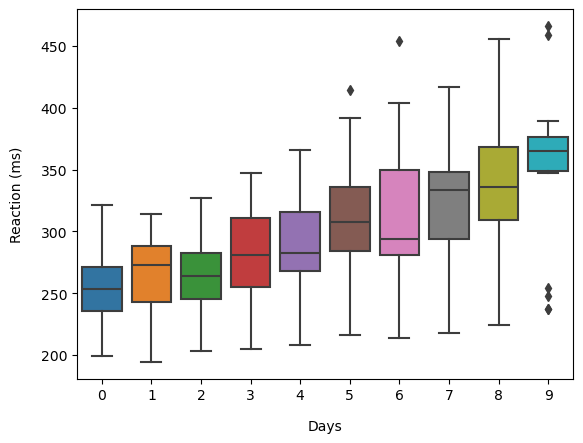

In [13]:
warnings.filterwarnings('ignore', category=FutureWarning)
sns.boxplot(x='Days', y='Reaction', data=sleep)
plt.ylabel('Reaction (ms)', labelpad=12)
plt.xlabel('Days', labelpad=12);

- The boxplot clearly illustrates that as a person experiences increased sleep deprivation, their reaction time worsens.

In [14]:
# Mean of reaction time grouped by day
sleep.groupby('Days')['Reaction'].mean()

Days
0    256.651806
1    264.495756
2    265.361900
3    282.992011
4    288.649422
5    308.518456
6    312.178256
7    318.750583
8    336.629506
9    350.851222
Name: Reaction, dtype: float64

<br>

**Construct and fit the hierarchical (mixed effects) Bayesian model**

In [16]:
# Initialize the model
mixed_effects_M = bmb.Model('Reaction ~ Days + (1|Subject) + (Days|Subject)', 
                            data=sleep)

Note that (1|Subject) and (Days|Subject) represent the specification of random effects in the model.

- **(1|Subject)** includes a subject-specific random intercept, which means that each subject has its own baseline value for the response variable (Reaction). It accounts for the variability between subjects that cannot be explained by the predictors in the model. Essentially, it allows for different starting points (intercepts) for each subject.

- **(Days|Subject)** includes a subject-specific random slope for Days (the predictor), which means that the effect of 'Days' on the response variable (Reaction) can vary from subject to subject. Essentially, it accounts for the variability in how the number of days (i.e. the amount of sleep deprivation) affects the response variable for each subject individually.

In [62]:
print(mixed_effects_M)

       Formula: Reaction ~ Days + (1|Subject) + (Days|Subject)
        Family: gaussian
          Link: mu = identity
  Observations: 180
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.0)
            Days ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|Subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            Days|Subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 56.1721)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


In [22]:
# Let's set the priors manually

common_prior = bmb.Prior('Normal', mu=0, sigma=0.5)
mixed_effects_M.set_priors(common = common_prior)

group_specific_sd = bmb.Prior('HalfNormal', sigma=1)
grou_specific_prior = bmb.Prior('Normal', mu=0, sigma=group_specific_sd)
mixed_effects_M.set_priors(group_specific = grou_specific_prior)

priors = {
    'Intercept': bmb.Prior('Normal', mu=0, sigma=10),
    'Days': bmb.Prior('Normal', mu=0, sigma=1)
}

mixed_effects_M.set_priors(priors=priors)

In [25]:
# Fit the model
mixed_effects_M_fitted = mixed_effects_M.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Reaction_sigma, Intercept, Days, 1|Subject_sigma, 1|Subject_offset, Days|Subject_sigma, Days|Subject_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [48]:
sigma_a = mixed_effects_M_fitted['posterior']['1|Subject_sigma'].values.flatten()
sigma_b = mixed_effects_M_fitted['posterior']['Days|Subject_sigma'].values.flatten()

In [54]:
print(f'Mean of sigma_a: {sigma_a.mean()}')

Mean of sigma_a: 0.946180906442835


In [55]:
print(f'95% posterior interval for sigma_a: {np.quantile(sigma_a, [0.025, 0.975])}')

95% posterior interval for sigma_a: [0.03207163 2.68301478]


In [56]:
print(f'Mean of sigma_b: {sigma_b.mean()}')

Mean of sigma_b: 8.79134365705692


In [57]:
print(f'95% posterior interval for sigma_b: {np.quantile(sigma_b, [0.025, 0.975])}')

95% posterior interval for sigma_b: [7.76320494 9.91970799]


<br>

<br>

<h3 align="left">Task 4</h3>

Let us examine the PISA data set, which contains the following variables

- mpist: test score (mathematics)
- sukup: gender
- SES: sosioeconomic status
- koulusij: school location (urban or rural)
- koulualue: school region (Northern, Eastern, Southern, or Western Finland)
- matem: previous mathematics grade
- aidink: previous native language grade

Fit at least two Bayesian models to the data, where the student's mathematics score (mpist) is explained by background factors. Examine the fit of the models to the data using posterior predictive distributions. Compare the models using cross-validation, choose the most suitable model for the data in your opinion.

In [2]:
pisa = pd.read_csv('/Users/herrakaava/Documents/Bayesian-Statistics-1/aineistot/pisa.csv',
                   index_col=0)

In [3]:
pisa.head()

,mpist,sukup,SES,koulusij,koulualue,matem,aidink
107,569.254,poika,0.1322,kaupunki,Etela-Suomi,9,7
1261,631.804,poika,1.1144,kaupunki,Etela-Suomi,8,8
381,521.582,tytto,0.4400,kaupunki,Etela-Suomi,7,9
721,560.686,tytto,0.9037,kaupunki,Etela-Suomi,8,8
2447,312.048,tytto,0.0085,kaupunki,Lansi-Suomi,6,9


<br>

When deciding which explanatory variables to include in the model, one can follow several approaches. I am going to choose the predictors based on correlation theoretical relevance / domain knowledge, correlation analysis, multicollinearity and statistical testing.

**Theoretical relevance / domain knowledge.**
- One can assume that matem (previous mathematics grade) is likely going to have an effect on the test score of mathematics.

**Correlation analysis**
- One can draw a heatmap which will show the correlation coefficients between each pair of variables in the dataset.

**Statistical significance**
- One can asses the statistical significance of each predictor using appropriate statistical tests (e.g., t-test, ANOVA). One should then include the predictors that are statistically significant.

Let us convert the categorical columns into numerical columns with the help of sklearn's LabelEncoder() function. This way we can calculate the correlation coefficient between the categorical columns and the response variable as well.

In [4]:
warnings.filterwarnings("ignore", message="is_sparse is deprecated", category=FutureWarning)

pisa_numerical = pisa.copy()

label_encoder = LabelEncoder()
categorical_columns = pisa_numerical.select_dtypes(include='object').columns

for col in categorical_columns:
    pisa_numerical[col] = label_encoder.fit_transform(pisa_numerical[col])

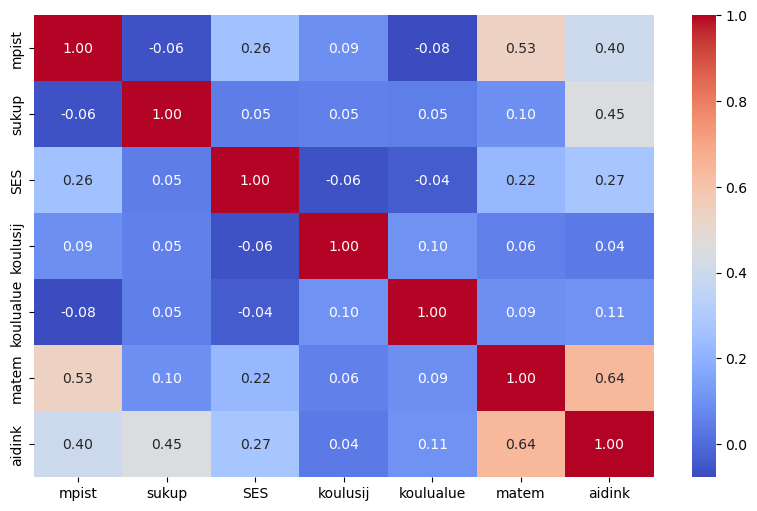

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(pisa_numerical.corr(),
            annot=True,
            cmap='coolwarm',
            fmt='.2f');

- As assumed before, the previous mathematics grade (matem) has the highest correlation with the response variable (mpist).
- aidink (previous native language grade) has also a moderate correlation with the response.

In [14]:
def calculate_vif(dataset):
    """
    Calculate the Variance Inflation Factor (VIF) for each predictor variable in a dataset.

    Variance inflation factor measures how much the behavior (variance) 
    of an independent variable is influenced, or inflated, 
    by its interaction/correlation with the other independent variables.

    Parameters:
        dataset (DataFrame): The input dataset containing predictor variables.

    Returns:
        DataFrame: A DataFrame containing the predictor names and their respective VIF values.
        The DataFrame has two columns: 'features' (predictor names) and 'VIF_value'.
    """
    vif = pd.DataFrame()
    vif["features"] = dataset.columns
    vif["VIF_value"] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    return(vif)

In [22]:
calculate_vif(pisa_numerical.drop('mpist', axis=1))

,features,VIF_value
0,sukup,2.585835
1,SES,1.190932
2,koulusij,1.267507
3,koulualue,1.843101
4,matem,54.024854
5,aidink,61.320385


- The predictors 'matem' and aidink' have both very high VIF values.
- In situations where predictors have very high VIF values, indicating a high degree of multicollinearity, it is advisable to address the issue by dropping one of the predictors associated with the high VIF values. Removing one of the correlated predictors can help alleviate multicollinearity and improve the stability and interpretability of the model.

In [23]:
calculate_vif(pisa_numerical.drop(['mpist', 'aidink'], axis=1))

,features,VIF_value
0,sukup,2.053675
1,SES,1.188536
2,koulusij,1.267490
3,koulualue,1.829744
4,matem,3.138711


- As seen above, when the predictor 'aidink' was dropped, the VIF value of matem dropped from 54 to 3.
- This indicates that one should not include both *matem* and *aidink* as predictors in the model.

**Statistical testing (ANOVA)**

In [29]:
def assess_anova(X, y):
    """
    Perform ANOVA to assess joint statistical significance of predictors.

    Parameters:
        X (DataFrame): Predictor variables.
        y (Series): Response variable.

    Returns:
        DataFrame: Anova results showing the F-statistic and p-value.
    """
    formula = 'y ~ ' + ' + '.join(X.columns)
    model = ols(formula=formula, data=pd.concat([X, y], axis=1)).fit()
    anova_results = anova_lm(model)
    return anova_results

In [30]:
X = pisa.drop('mpist', axis=1)
y = pisa['mpist']

In [31]:
assess_anova(X, y)

,df,sum_sq,mean_sq,F,PR(>F)
sukup,1.0,4629.160938,4629.160938,1.212243,2.722739e-01
koulusij,1.0,11112.858789,11112.858789,2.910136,8.964997e-02
koulualue,3.0,34768.470665,11589.490222,3.034952,3.040610e-02
SES,1.0,76172.264949,76172.264949,19.947310,1.360458e-05
matem,1.0,282696.605851,282696.605851,74.030054,2.793671e-15
aidink,1.0,24353.782221,24353.782221,6.377550,1.237012e-02
Residual,191.0,729366.641374,3818.673515,NaN,NaN


- Not significant: sukup, koulusij. 
- Significant: koulualue, aidink.
- Highly significant: SES, matem. 

**model1**:
- Let's include the highly significant predictors in the first model.

In [153]:
with pm.Model() as model1:
    
    matem = pm.MutableData('matem', pisa_numerical['matem'].values)
    SES = pm.MutableData('SES', pisa_numerical['SES'].values)
    mpist = pm.MutableData('mpist', pisa_numerical['mpist'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=50, sigma=10.0)
    beta1 = pm.Normal('beta1', mu=10, sigma=10.0)
    beta2 = pm.Normal('beta2', mu=10, sigma=10.0)
    sigma = pm.HalfNormal('sigma', sigma=10.0)
    
    # Expected value
    mu = pm.Deterministic('mu', alpha + beta1*matem + beta2*SES)
    
    # Likelihood
    y = pm.Normal('y',
                  mu=mu,
                  sigma=sigma,
                  observed=mpist)
    
    trace_model1 = pm.sample(draws=1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [154]:
# Generate posterior predictive samples from a model given a trace
posterior_preds1 = pm.sample_posterior_predictive(trace_model1, model=model1)

Sampling: [y]


<br>

**model2**:
- Let's add an interaction between matem and SES in the second model and also include the koulualue predictor. Recall that including both matem and aidink resulted in a problematic multicollinearity. Therefore we're not going to include aidink as a predictor.

In [155]:
with pm.Model() as model2:
    
    matem = pm.MutableData('matem', pisa_numerical['matem'].values)
    SES = pm.MutableData('SES', pisa_numerical['SES'].values)
    koulualue = pm.MutableData('koulualue', pisa_numerical['koulualue'].values)
    mpist = pm.MutableData('mpist', pisa_numerical['mpist'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=50, sigma=10.0)
    beta1 = pm.Normal('beta1', mu=10, sigma=10.0)
    beta2 = pm.Normal('beta2', mu=10, sigma=10.0)
    beta3 = pm.Normal('beta3', mu=10, sigma=10.0)
    sigma = pm.HalfNormal('sigma', sigma=10.0)
    
    # Expected value
    mu = pm.Deterministic('mu', 
                          alpha + beta1*matem + beta2*SES + beta3*koulualue + matem*SES)
    
    # Likelihood
    y = pm.Normal('y',
                  mu=mu,
                  sigma=sigma,
                  observed=mpist)
    
    trace_model2 = pm.sample(draws=1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [156]:
# Generate posterior predictive samples from a model given a trace
posterior_preds2 = pm.sample_posterior_predictive(trace_model2, model=model2)

Sampling: [y]


<br>

**Visualize the posterior predictive distributions together with the observed data**

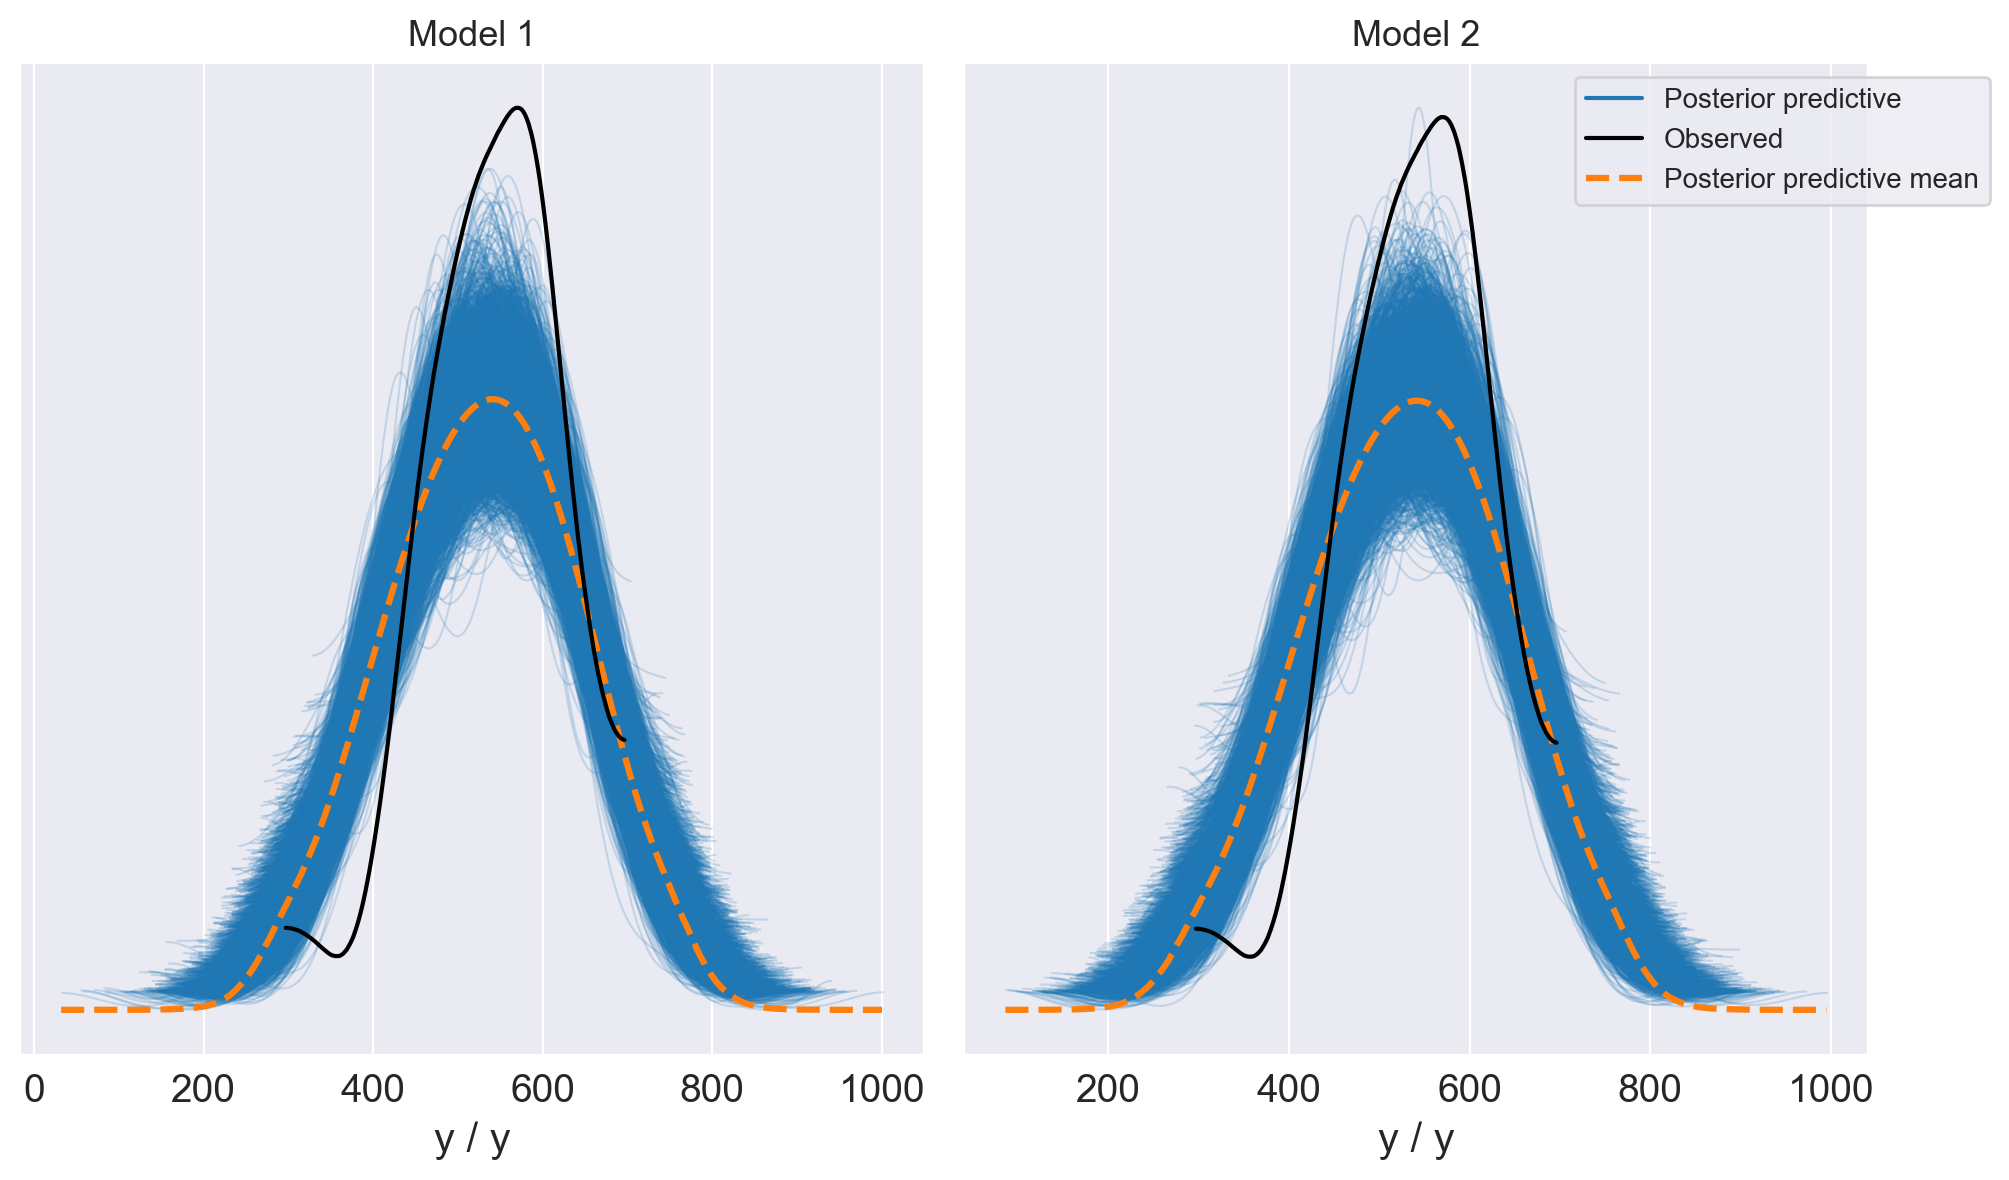

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), dpi=200)
sns.set_style('darkgrid')

az.plot_ppc(posterior_preds2, ax=ax[0], legend=False)
ax[0].set_title('Model 1', size=13)

az.plot_ppc(posterior_preds1, ax=ax[1])
ax[1].set_title('Model 2', size=13)

plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout();

- Posterior predictive plot. The blue lines represent samples from the posterior predictive distribution, and the black line represents the observed data.

Based on the posterior predictive distributions, these models might not be ideal for this data because the posterior predictive means are far away from the observed data.

<br>

**Leave-one-out Cross-validation ([LOO](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html))**

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples (without the need for re-fitting the data). This approximation is based on importance sampling. The importance weights are stabilized using a method known as Pareto-smoothed importance sampling (PSIS).

One can compare models based on their expected log pointwise predictive density (ELPD) by using the function **compare()** provided by the ArviZ library. This function is similar (or equivalent) to R's loo_compare() function. The ELPD is estimated either by Pareto smoothed importance sampling leave-one-out
cross-validation (LOO) or using the widely applicable information criterion (WAIC).

$$ elpd_{loo} = \sum\limits_{i=1}^{n} log \, p (y_i|y_{-i}), $$

where $\, y_{-i} \,$ refers to the data without the observation $\, y_{i} \,$ (n is the size of the data).

In order to compute LOO and WAIC, ArviZ needs to acces to the model element-wise log-likelihood for every posterior sample. One can add it via *compute_log_likelihood()* function. Alternatively we can pass idata_kwargs={"log_likelihood": True} to sample() to have it computed automatically at the end of sampling.

In [158]:
with model1:
    pm.compute_log_likelihood(trace_model1)

In [159]:
model1_LOO = az.loo(trace_model1)

In [160]:
with model2:
    pm.compute_log_likelihood(trace_model2)

In [161]:
model2_LOO = az.loo(trace_model2)

In [164]:
# Compare the models
az.compare({'model1': trace_model1, 'model2': trace_model2}, ic='loo')

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1,0,-1158.846654,3.253242,0.000000,1.000000e+00,12.669759,0.000000,False,log
model2,1,-1160.110047,4.505262,1.263393,1.110223e-16,12.726877,0.738404,False,log


- A bigger **elpd_loo** value indicates a better fit to the data. They are very close to each other (as illustrated with the posterior predictive distributions). However, model1 has a slightly bigger elpd_loo value, and this is the final model to go with.

This observation aligns with the principle of Occam's razor, which suggests that simpler models that explain the data well are preferred over more complex models unless the added complexity provides a substantial improvement in explaining the data. In this case, it seems that the interaction term and additional predictors in model2 did not substantially improve the model fit, as evidenced by the similar weights and the slightly worse performance compared to model1 in terms of LOO.